<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/02_Image_Segmentation.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segmentation





In [1]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.1 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0),
                               w,
                               h, edgecolor='green',
                               facecolor=(0,0,0,0),
                               lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0],
               pos_points[:, 1],
               color='green',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0],
               neg_points[:, 1],
               color='red',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
      mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
      mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
      fig = plt.gcf()
      return fig2img(fig)




def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

Code to suppress warnings

In [2]:
from transformers.utils import logging
logging.set_verbosity_error()

In [4]:
from transformers import pipeline
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

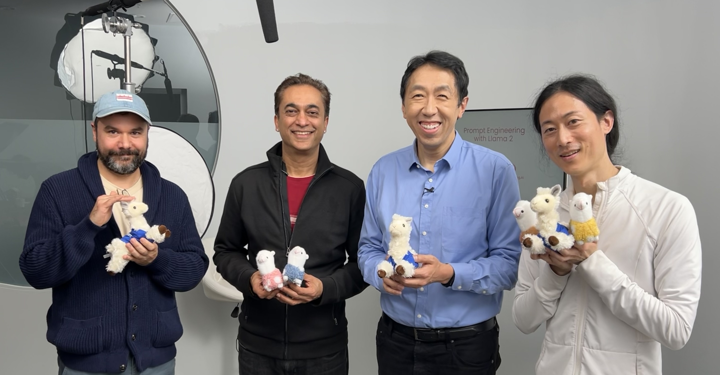

In [19]:
from PIL import Image
import io
from io import BytesIO
import requests
# Fetch image from URL
url = 'https://github.com/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/Images/meta_llamas.jpg?raw=true'  # Replace with your image URL
response = requests.get(url)
raw_image = Image.open(BytesIO(response.content))
raw_image.resize((720, 375))

In [21]:
output = sam_pipe(raw_image, points_per_batch=32)

KeyboardInterrupt: 

In [ ]:
show_pipe_masks_on_image(raw_image, output)

Faster Inference: Infer an Image and a Single Point

In [22]:
from transformers import SamModel, SamProcessor

In [23]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

In [24]:
input_points = [[[1600, 700]]]

In [25]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

In [26]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

In [27]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

len(predicted_masks)

predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 1500, 2880])

In [28]:
outputs.iou_scores

tensor([[[0.9583, 0.9551, 0.9580]]])

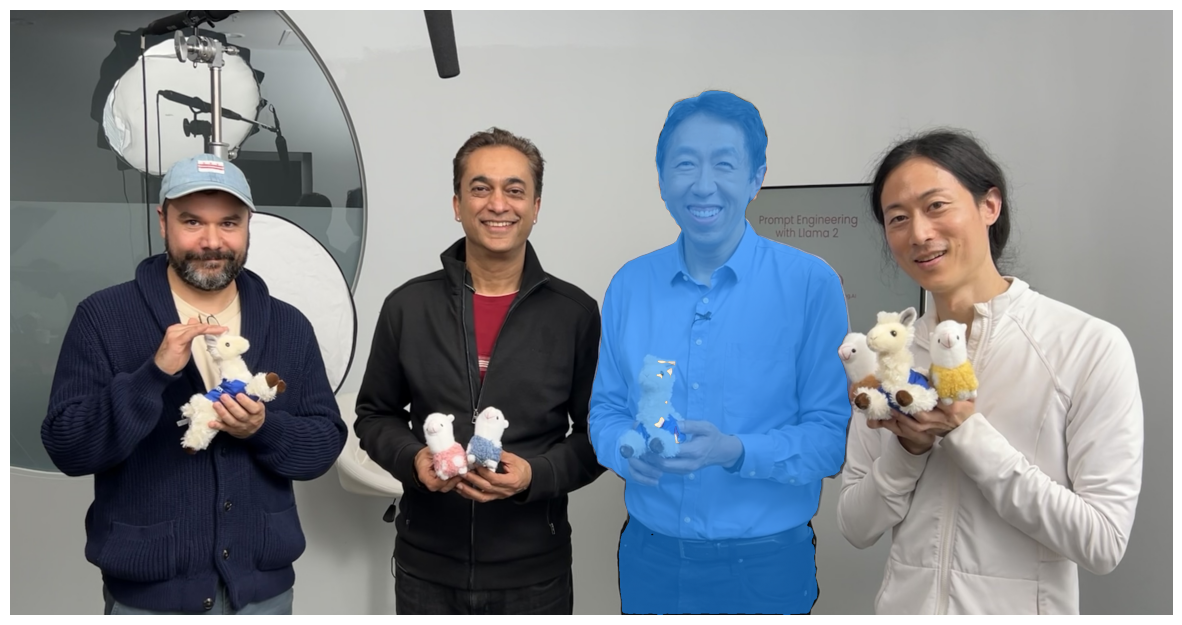

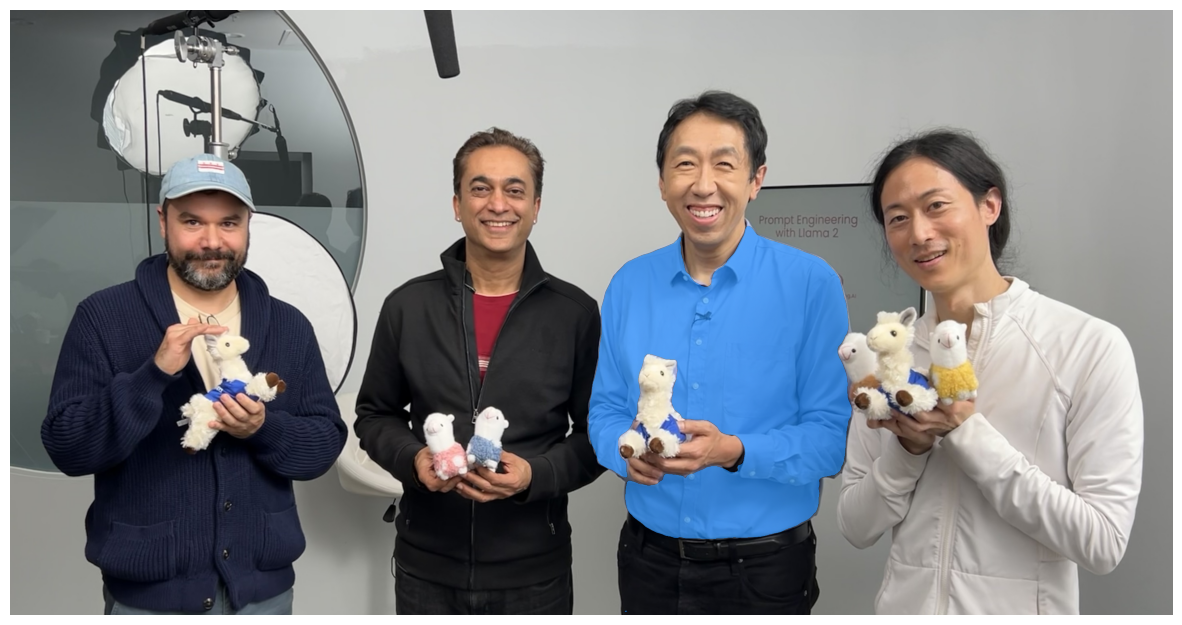

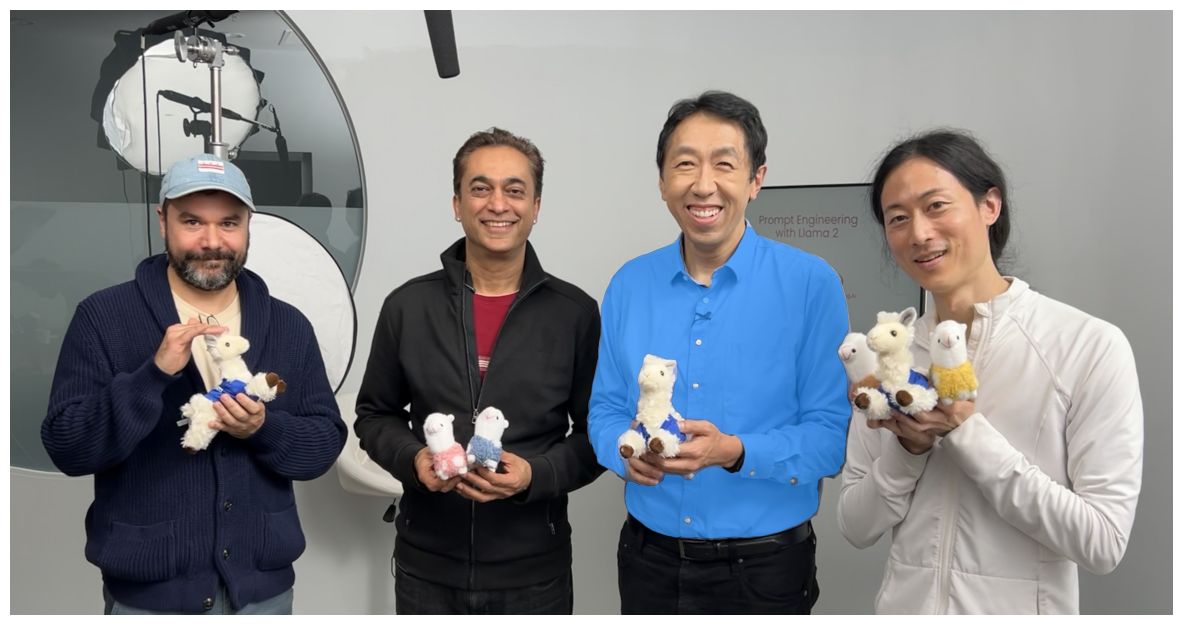

In [29]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

Depth Estimation with DPT

In [30]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

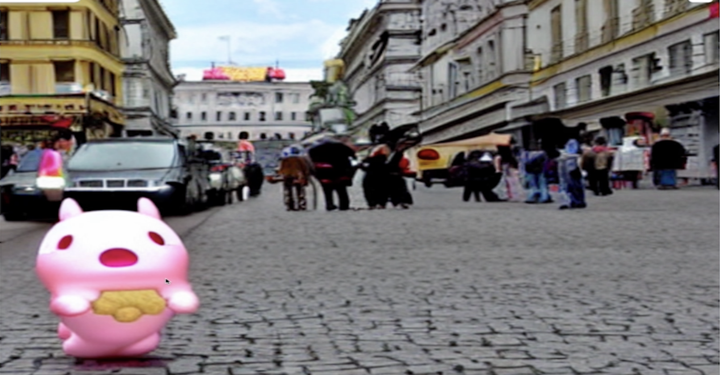

In [31]:
from PIL import Image
import io
from io import BytesIO
import requests
# Fetch image from URL
url = 'https://github.com/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/Images/gradio_tamagochi_vienna.png?raw=true'  # Replace with your image URL
response = requests.get(url)
raw_image = Image.open(BytesIO(response.content))
raw_image.resize((720, 375))

In [32]:
output = depth_estimator(raw_image)
output

{'predicted_depth': tensor([[[ 248.4070,  252.1829,  256.9170,  ...,  595.8293,  591.8105,
            471.2294],
          [ 247.3371,  254.8536,  257.9680,  ...,  596.0250,  589.0449,
            594.1439],
          [ 259.7673,  259.5480,  261.4166,  ...,  597.6287,  595.3369,
            595.7491],
          ...,
          [3014.1091, 3018.4861, 3019.1719,  ..., 3275.2781, 3269.3459,
           3268.8369],
          [3041.5544, 3040.2783, 3044.4644,  ..., 3280.7483, 3289.3672,
           3274.8713],
          [3039.7495, 3056.0349, 3052.9734,  ..., 3302.0000, 3298.1899,
           3286.9138]]]),
 'depth': <PIL.Image.Image image mode=L size=1612x1242>}

In [33]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [34]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

In [35]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [36]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [37]:
raw_image.size[::-1],

((1242, 1612),)

In [38]:
prediction

tensor([[[[ 248.1577,  248.2614,  248.7576,  ...,  468.0626,  447.0033,
            442.8550],
          [ 248.0309,  248.1445,  248.6918,  ...,  477.7612,  458.3926,
            454.5767],
          [ 247.0835,  247.2386,  247.9993,  ...,  508.8531,  494.9497,
            492.2079],
          ...,
          [3040.0393, 3040.3989, 3042.2324,  ..., 3285.1289, 3283.1475,
           3282.7578],
          [3037.8716, 3038.3877, 3041.0291,  ..., 3288.0652, 3286.3364,
           3285.9917],
          [3037.5520, 3038.1143, 3040.9961,  ..., 3289.0701, 3287.3911,
           3287.0552]]]])

In [39]:
import numpy as np

In [40]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

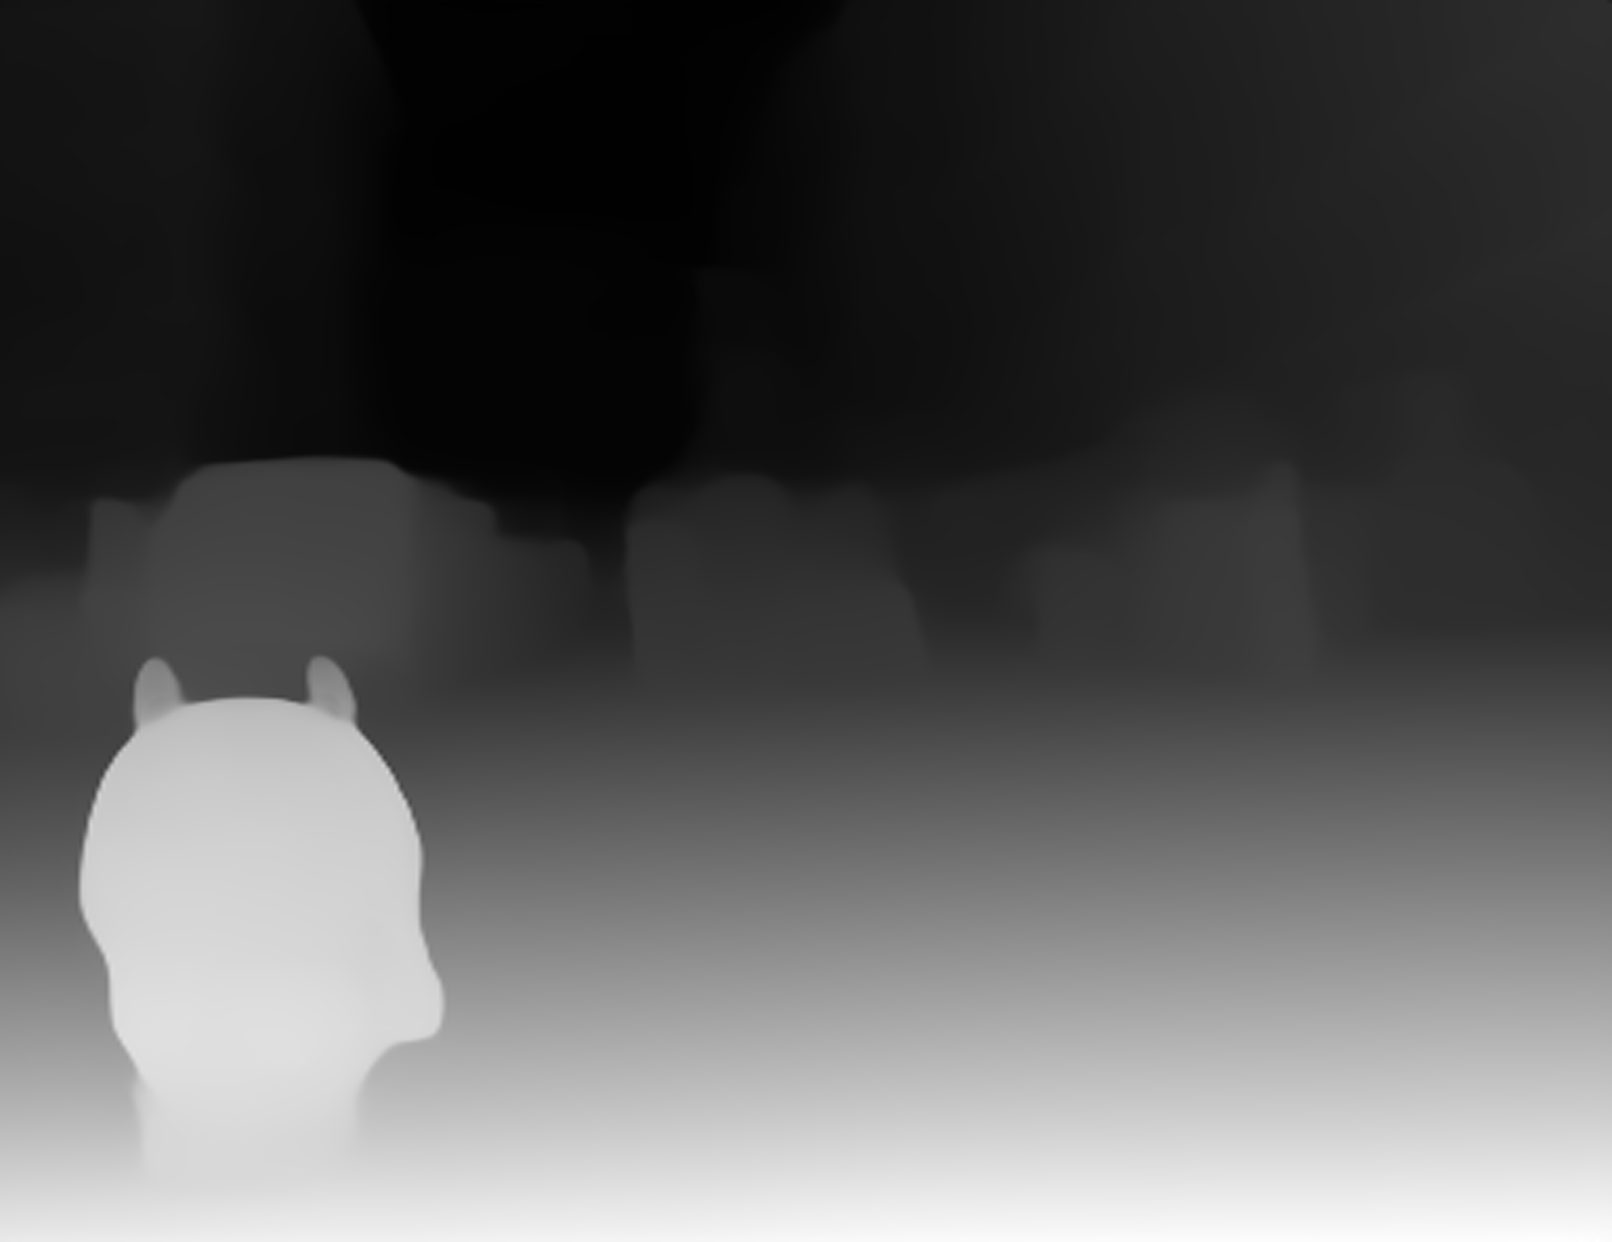

In [41]:
depth

In [42]:
import os
import gradio as gr
from transformers import pipeline

In [43]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [44]:
iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs=gr.Image(type='pil'))

In [45]:
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8efd59e3c7c2c6f747.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [46]:
iface.close()

Closing server running on port: 7860
